In [ ]:
# LC08_L2SP_168056_20240302_20240314_02_T1
# LC09_L2SP_168056_20240310_20240311_02_T1

In [1]:
import tifffile as tiff
import numpy as np

def get_RGB(ID):
    # D:\Cloud Removal\data\LC09_L2SP_175083_20230410_20230412_02_T1\LC09_L2SP_175083_20230410_20230412_02_T1_SR_B4.TIF
    # Load Blue (B2), Green (B3) and Red (B4) bands
    B2 = tiff.imread('D:\Cloud Removal\data/{}/{}_SR_B2.TIF'.format(ID, ID))
    B3 = tiff.imread('D:\Cloud Removal\data/{}/{}_SR_B3.TIF'.format(ID, ID))
    B4 = tiff.imread('D:\Cloud Removal\data/{}/{}_SR_B4.TIF'.format(ID, ID))

    # Stack and scale bands
    RGB = np.dstack((B4, B3, B2))
    RGB = np.clip(RGB*0.0000275-0.2, 0, 1)

    # Clip to enhance contrast
    RGB = np.clip(RGB,0,0.3)/0.3

    return RGB

In [2]:
import matplotlib.pyplot as plt

ID = 'LC09_L2SP_168056_20240310_20240311_02_T1'
RGB = get_RGB(ID)

# Plot the RGB image
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.imshow(RGB)

In [3]:
def get_mask(val,type='cloud'):
    
    """Get mask for a specific cover type"""

    # convert to binary
    bin_ = '{0:016b}'.format(val)

    # reverse string
    str_bin = str(bin_)[::-1]

    # get bit for cover type
    bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2}
    bit = str_bin[bits[type]]

    if bit == '1':
        return 0 # cover
    else:
        return 1 # no cover

In [4]:
# QA band
QA = tiff.imread('D:\Cloud removal\data/{}/{}_QA_PIXEL.TIF'.format(ID, ID))
QA = np.array(QA)

In [5]:
# Get masks
cloud_mask = np.vectorize(get_mask)(QA,type='cloud')

In [6]:
shadow_mask = np.vectorize(get_mask)(QA,type='shadow')

In [7]:
dilated_cloud_mask = np.vectorize(get_mask)(QA,type='dilated_cloud')

In [8]:
cirrus_mask = np.vectorize(get_mask)(QA,type='cirrus')

In [9]:
import cv2
import matplotlib as mpl

# segmentation image
seg = RGB.copy()

# color for each cover type
colors = np.array([[247, 2, 7],
                    [201, 116, 247],
                    [0, 234, 255],
                    [3, 252, 53]])/255

masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

for i,mask in enumerate(masks):

    # color for cover type
    temp = seg.copy()
    temp[mask == 0] = colors[i]

    # add to segmentation
    seg = cv2.addWeighted(seg, 0.5, temp, 0.5, 0)

# fig, ax = plt.subplots(1,2,figsize=(20, 10))

# ax[0].imshow(seg)

# add legend with colors for each cover type
legend_elements = [mpl.patches.Patch(facecolor=colors[0], label='Cloud'),
                     mpl.patches.Patch(facecolor=colors[1], label='Shadow'),
                        mpl.patches.Patch(facecolor=colors[2], label='Dilated Cloud'),
                        mpl.patches.Patch(facecolor=colors[3], label='Cirrus')]

# ax[0].legend(handles=legend_elements, loc='upper right')

# draw white rectangle around area of interest
h = 250
x,y = 3000,3000
rect = mpl.patches.Rectangle((x-h,y-h),h*2,h*2,linewidth=2,edgecolor='w',facecolor='none')
# ax[0].add_patch(rect)

# crop area of interest
crop_seg =  seg[y-h:y+h,x-h:x+h,:]

# ax[1].imshow(crop_seg)

# ax[0].set_axis_off()
# ax[1].set_axis_off()
# ax[0].set_title('Segmented Image')
# ax[1].set_title('Cropped Segmented Image')

In [10]:
# IDs for cloudy and non-cloudy images
IDs = ['LC09_L2SP_168056_20240310_20240311_02_T1',
       'LC08_L2SP_168056_20240302_20240314_02_T1']

# Get RGB
# cloudy = get_RGB(IDs[0])
clear = get_RGB(IDs[1])

In [11]:
# get mask for cloudy image
mask = cloud_mask*shadow_mask*dilated_cloud_mask*cirrus_mask


In [12]:
# remove cloudy pixels and fill with adjusted clear pixels
rm_mask = RGB*mask[:, :, np.newaxis]

In [13]:
import rasterio as rio

# Open red band with rasterio for geolocation
geo_cloudy = rio.open('D:\Cloud Removal\data/{}/{}_SR_B4.TIF'.format(IDs[0], IDs[0]))
geo_clear = rio.open('D:\Cloud Removal\data/{}/{}_SR_B4.TIF'.format(IDs[1], IDs[1]))

In [14]:
# get UTM coordinates from cloudy image
utmx, utmy = geo_cloudy.xy(y,x)

# get pixels from clear image
y_,x_ = geo_clear.index(utmx, utmy)
print(x_,y_)

2940 3000


In [15]:
# get pixel coordinates of clear image corners
y,x = geo_clear.read(1).shape
clear_ul = (0,0) # upper left
clear_lr = (y,x) # lower right

In [16]:
# get pixel coordinates of cloudy image corners
cloudy_bounds = geo_cloudy.bounds
new_clear_ul = geo_clear.index(cloudy_bounds.left,cloudy_bounds.top)
new_clear_lr = geo_clear.index(cloudy_bounds.right,cloudy_bounds.bottom)

In [17]:
# calculate pixel adjustment 
top_adj = clear_ul[0] - new_clear_ul[0]
bottom_adj = new_clear_lr[0] - clear_lr[0]

left_adj = clear_ul[1] -  new_clear_ul[1]
right_adj = new_clear_lr[1] - clear_lr[1]

print(top_adj, bottom_adj, left_adj, right_adj)

0 -10 60 -60


In [18]:
def adjust_rgb(rgb,top_adj, bottom_adj, left_adj, right_adj):

    adj_rgb = rgb.copy()

    #Adding black pixels 
    if top_adj > 0:
        add_top = np.zeros((top_adj,rgb.shape[1],3))
        adj_rgb = np.vstack((add_top,adj_rgb))
    if bottom_adj > 0:
        add_bottom = np.zeros((bottom_adj,rgb.shape[1],3))
        adj_rgb = np.vstack((adj_rgb,add_bottom))
    if left_adj > 0:
        add_left = np.zeros((rgb.shape[0],left_adj,3))
        adj_rgb = np.hstack((add_left,adj_rgb))
    if right_adj > 0:
        add_right = np.zeros((rgb.shape[0],right_adj,3))
        adj_rgb = np.hstack((adj_rgb,add_right))
    
    #Removing pixels
    if top_adj < 0:
        adj_rgb = adj_rgb[-top_adj:,:,:]
    if bottom_adj < 0:
        adj_rgb = adj_rgb[:bottom_adj,:,:]
    if left_adj < 0:
        adj_rgb = adj_rgb[:,-left_adj:,:]
    if right_adj < 0:
        adj_rgb = adj_rgb[:,:right_adj,:]

    return adj_rgb

In [19]:
# Get RGB images
# cloudy_RGB = get_RGB(IDs[0])
# clear_RGB = get_RGB(IDs[1])

# Adjust clear RGB image
clear_RGB_adj = adjust_rgb(clear,top_adj, bottom_adj, left_adj, right_adj)

# get mask for cloudy image
# mask = cloud_mask*shadow_mask*dilated_cloud_mask*cirrus_mask

# remove cloudy pixels and fill with adjusted clear pixels
# rm_mask = RGB*mask[:, :, np.newaxis]
fill_mask = clear_RGB_adj*(1-mask[:, :, np.newaxis])


In [20]:
inpaint = rm_mask+fill_mask

Text(0.5, 1.0, 'Generated Inpainted Image')

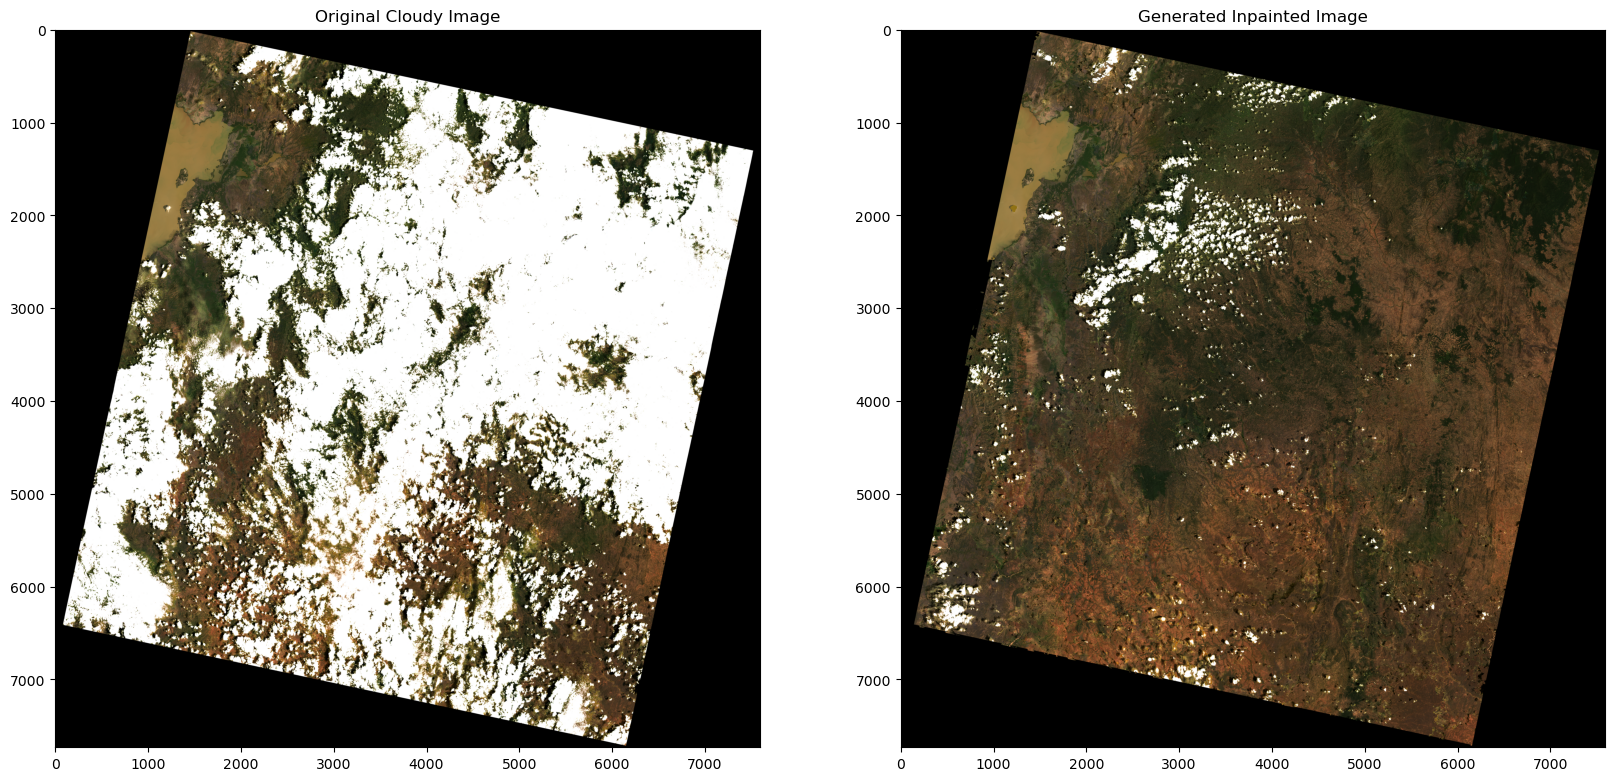

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(RGB)
ax[1].imshow(inpaint)

ax[0].set_title('Original Cloudy Image')
ax[1].set_title('Generated Inpainted Image')

Text(0.5, 1.0, 'Generated Inpainted Image')

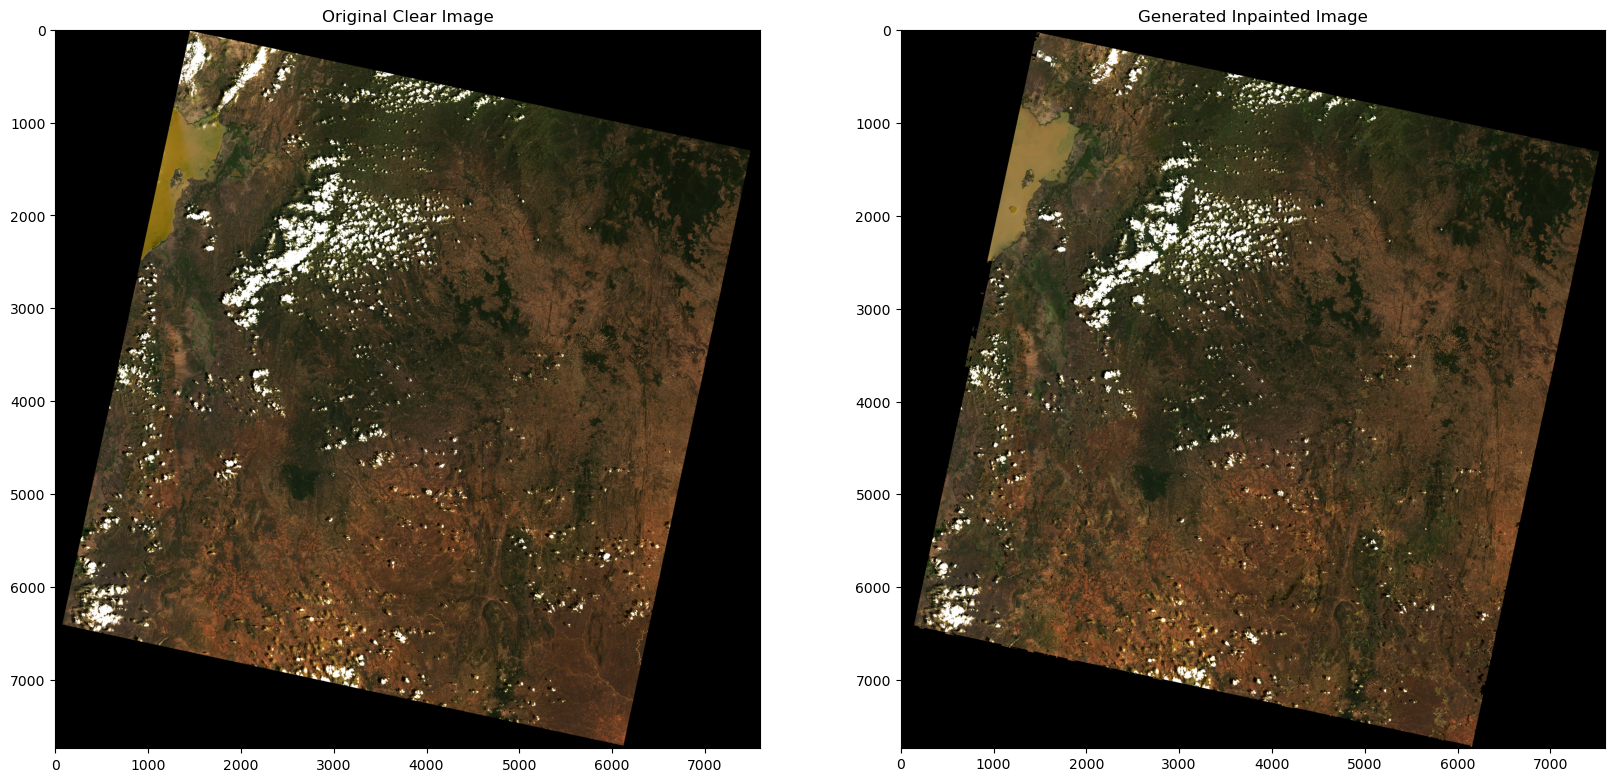

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(clear)
ax[1].imshow(inpaint)

ax[0].set_title('Original Clear Image')
ax[1].set_title('Generated Inpainted Image')